<a href="https://colab.research.google.com/github/jumbokh/nknu-class/blob/main/notebooks/CNN_2_GAN_Apple_wget.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[data source: quickdraw_gcp](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap)

In [ ]:
!wget -O full_numpy_bitmap_apple.npy https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy

--2021-08-25 11:54:28--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113462128 (108M) [application/octet-stream]
Saving to: ‘full_numpy_bitmap_apple.npy’

full_numpy_bitmap_a 100%[===================>] 108.21M   257MB/s    in 0.4s    

2021-08-25 11:54:29 (257 MB/s) - ‘full_numpy_bitmap_apple.npy’ saved [113462128/113462128]



In [ ]:
# Eiffel Tower
#!wget -O full_numpy_bitmap_Eiffel.npy https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/The%20Eiffel%20Tower.npy

In [ ]:
# https://github.com/ytakzk/GAN-DCGAN-for-Keras/blob/master/DCGAN.ipynb


from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
#from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization

from keras.layers.advanced_activations import LeakyReLU
#from keras.optimizers import Adam

from tensorflow.keras.optimizers import Adam

#from keras.datasets import mnist

from tqdm import tqdm
# https://codertw.com/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80/360929/  tqdm 教學
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
X_train = np.load('full_numpy_bitmap_apple.npy',encoding='bytes',allow_pickle=True)
X_train.astype('float32')
X_train=X_train.reshape(-1,28,28,1)
#X_train = X_train/255.0 # 啊，不夠黑
X_train = -(X_train / 127.5 - 1.0)  # *-1 會不會反白？
print(X_train.shape)
print('X_train shape', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_train[0].shape)

(144722, 28, 28, 1)
X_train shape (144722, 28, 28, 1)
144722 train samples
(28, 28, 1)


In [ ]:
def Generator():
  
    model = Sequential()
    model.add(Dense(1024, input_dim=100))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, kernel_size=(5, 5), padding='same'))
    model.add(Activation('tanh'))
    #print(model.summary())
    return model
Generator()

In [ ]:
def Discriminator():
    
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2)))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optimizer = Adam(lr=1e-5, beta_1=0.1)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return model

In [ ]:
def DCGAN(generator, discriminator):

    discriminator.trainable = False # 我們為什麼可以讓這個 "discriminator" 具有這個特性？ 勢必是 discriminator 引數帶入一個 keras model 

    model = Sequential()
    
    model.add(generator)  # 這樣也可以？  不是都是 add layer 嗎？
    model.add(discriminator)
    
    optimizer = Adam(lr=2e-4, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return model

In [ ]:
generator = Generator()
discriminator = Discriminator()
gan = DCGAN(generator, discriminator)

epochs = 30
batch_size = 32
input_size = 100

num_batches = int(X_train.shape[0] / batch_size)

pbar = tqdm(total=epochs * num_batches/batch_size)

gan_loss = []
discriminator_loss = []

for epoch in range(epochs):
    for index in range(num_batches):  #num_batches 相當於 steps_per_epoch, but fixed data numbers not generated from ImageDataGenerator... 
        #if index%100 == 0:
        pbar.update(1)
        # Generative data  生成端的隨機向量輸入矩陣 (每一次都把 batch 量備好)
        noise = np.random.uniform(-1, 1, size=[batch_size, input_size])   
        # [32, 100]  32個 noise, 每一個 noise 有 100維
        generated_data = generator.predict_on_batch(noise)  
        # 所以我們有 32 張騙人的照片

        # Training data chosen from Mnist samples，挑出32張真的照片
        training_data = X_train[index * batch_size: (index + 1) * batch_size]

        X = np.vstack((generated_data, training_data))  # numpy.concatenate(axis=0)
        y = np.zeros(2 * batch_size)
        y[:batch_size] = 1  # 前面是 generator 來的所以 label 應該是 0, 後面是我們備好的真的圖片，label = 1

        # Train discriminator
        #if index%2==0:
        d_loss = discriminator.train_on_batch(x=X, y=y)  # <== Training
      
        # ====================== 開始訓練 Generator ===============
        # Train generator (Seemingly train GAN but the discriminator in the model is disabled to train.)
        noise = np.random.uniform(-1, 1, size=[batch_size, input_size])
        y = np.zeros(batch_size)
        g_loss = gan.train_on_batch(x=noise, y=y)  # <== Traing

        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
        img = generated_images = generator.predict(noise)

        # === 以上留意，訓練是訓練 model gan(DCGAN), 取照片是取 generator 的照片

    # Plot losses
    if epoch%10 ==0:  # we won't save to many loss record png
      fig = plt.figure(figsize=(10, 5))        
      fig.suptitle('epoch: ' + str(epoch + 1))
      plt.plot(discriminator_loss, label="discriminator's loss", color='b')
      plt.plot(gan_loss, label="generator's loss", color='r')
      plt.xlim([0, epochs * num_batches])
      plt.legend()
      plt.savefig(str(epoch + 1) + 'applelosw140Ks.png')
      plt.close()      

    # Visualize generated data
    generated_images = generator.predict(noise)

    fig = plt.figure(figsize=(9, 9))        
    for i in range(9):
        plt.subplot(3, 3, i+1)
        img = generated_images[i, :] * 0.5 + 0.5
        img = img.reshape((28, 28))
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.savefig( str(epoch + 1) + 'appleganw140K.png')
    plt.close()     
        
pbar.close()


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
135660it [1:51:31, 20.27it/s]


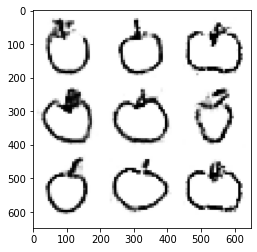

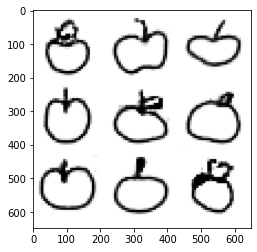

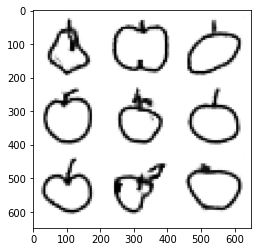

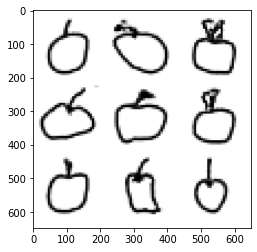

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread('1appleganw140K.png'))
plt.show()
plt.imshow(plt.imread('10appleganw140K.png'))
plt.show()
plt.imshow(plt.imread('20appleganw140K.png'))
plt.show()
plt.imshow(plt.imread('30appleganw140K.png'))